Generatively Pretrained Transformer (GPT)
https://arxiv.org/pdf/1706.03762

<h3> 1. Import Libraries </h3>

In [1]:
from platform import python_version

print(python_version())

3.8.10


In [3]:
import subprocess

# list of modules to install and their corresponding names
modules = {'tensorflow': 'tf',
           'numpy': 'np',
           'pandas': 'pd',
           'requests': 'requests',
           'tiktoken': 'tiktoken',
           'openai': 'openai',
           'torch': 'torch',
           'torch.nn': 'nn',
           'matplotlib.pyplot': 'plt',
           'torch.nn.functional': 'F',
           'bs4': 'bs4',
           're': 're',
           'os': 'os',
          'json': 'json'}

# iterate over the modules and install them if necessary
for module, name in modules.items():
    try:
        exec(f"import {module} as {name}")
    except ModuleNotFoundError as error:
        print(f"{error.name} module not found. Installing {error.name}...")
        try:
            subprocess.check_call(["pip", "install", error.name])
        except:
            print(f"Installation of {module} failed.")
    else:
        continue
print("All specified modules loaded")

All specified modules loaded


<b> Check for available GPUs for Training </b> 

In [4]:
# Check for GPUs
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus

<h3> 2. Import Data </h3> 

In [5]:
def fetch_html(url):
    response = requests.get(url)
    html_content = response.content
    return html_content

def remove_special_chars(text):
    return re.sub(r'\xa0', '', text)

def process_html(html_content):
    soup = bs4.BeautifulSoup(html_content, 'html.parser')
    
    # Remove page number expressions
    for pbtext in soup.find_all('span', class_='pbtext'):
        pbtext.decompose()

    entries = []
    
    for h2 in soup.find_all('h2'):
        title = remove_special_chars(h2.get_text(strip=True))
        
        text_div = h2.find_next('div', attrs={'class': 'textindentlevelx'})
        opener_div = text_div.find('div', attrs={'class': 'opener'})
        opener = remove_special_chars(opener_div.get_text(strip=True, separator=' ')) if opener_div else ''
        text = remove_special_chars(' '.join(p.get_text(strip=True, separator=' ') for p in text_div.find_all('p')))

        annotation_div = text_div.find_next_sibling('div', attrs={'class': 'textindentlevelx'})
        annotation = remove_special_chars(' '.join(p.get_text(strip=True, separator=' ') for p in annotation_div.find_all('p')))
        
        entry = {
            'title': title,
            'opener': opener,
            'text': text,
            'annotation': annotation
        }
        entries.append(entry)
    
    return entries

def remove_bracketed_numbers(text):
    return re.sub(r'\[\d+\]', '', text)

def create_text_file(entries, output_filename):
    full_text = ''
    with open(output_filename, 'w', encoding='utf-8') as f:
        for entry in entries:
            title = remove_bracketed_numbers(entry['title'])
            opener = remove_bracketed_numbers(entry['opener'])
            text = remove_bracketed_numbers(entry['text'])

            entry_text = f"{title}\n{opener}\n{text}\n\n"
            full_text += entry_text
            f.write(entry_text)
    
    return full_text

def get_texts(url, filename):
    html_content = fetch_html(url)
    entries = process_html(html_content)
    full_text = create_text_file(entries, filename)

    return html_content, entries, full_text

def process_volumes():
    for i in range(1, 9):
        filename = f'lincoln_volume_{i}.txt'

        if os.path.isfile(filename):
            print(f'File for {filename} already exists. Skipping.')
        else:
            link = f'https://quod.lib.umich.edu/l/lincoln/lincoln{i}?rgn=main;view=fulltext'
            html_content, entries, full_text = get_texts(link, filename)
            print(f'Files for {filename} written to disk.')

            # Store objects in memory with different names
            globals()[f'l{i}_html_content'] = html_content
            globals()[f'l{i}_entries'] = entries
            globals()[f'l{i}_full_text'] = full_text
            
            # Save HTML and JSON files with correct naming format
            html_filename = f'lincoln_v{i}_webpage.html'
            json_filename = f'lincoln_v{i}_entries.json'
            
            with open(html_filename, 'w', encoding='utf-8') as f:
                f.write(html_content.decode())
            
            with open(json_filename, 'w', encoding='utf-8') as f:
                json.dump(entries, f, ensure_ascii=False, indent=4)

  

In [6]:
process_volumes()

Files for lincoln_volume_1.txt written to disk.
Files for lincoln_volume_2.txt written to disk.
Files for lincoln_volume_3.txt written to disk.
Files for lincoln_volume_4.txt written to disk.
Files for lincoln_volume_5.txt written to disk.
Files for lincoln_volume_6.txt written to disk.
Files for lincoln_volume_7.txt written to disk.
Files for lincoln_volume_8.txt written to disk.


In [7]:
def concatenate_text_files(filenames):
    long_text = ''
    for filename in filenames:
        with open(filename, 'r', encoding='utf-8') as f:
            file_text = f.read()
            long_text += file_text
    return long_text

In [8]:
filenames = ['lincoln_volume_1.txt',
             'lincoln_volume_2.txt',
             'lincoln_volume_3.txt',
             'lincoln_volume_4.txt',
             'lincoln_volume_5.txt',
             'lincoln_volume_6.txt',
             'lincoln_volume_7.txt',
             'lincoln_volume_8.txt']

text = concatenate_text_files(filenames)

<h3> 3. Basic Data Exploration </h3> 

<h3> 4. Create Basic Tokenization Functions and Encode Data </h3> 

<b> Encoding 2: Subword OpenAI GPT2 Dictionary</b>

In [9]:
# open ai tokenizer function goes here (tiktoken)
gpt2enc = tiktoken.get_encoding('gpt2')
# gpt4enc = tiktoken.get_encoding('cl100k_base')
vocab_size=gpt2enc.n_vocab
print(f"The length of the gpt2 encoding dictionary is {vocab_size}")
print(gpt2enc.encode("Hello World"))
print(gpt2enc.decode(gpt2enc.encode("Hello World")))

The length of the gpt2 encoding dictionary is 50257
[15496, 2159]
Hello World


In [10]:
# Sentence piece from google

<h3> 5. Encode Dataset </h3>

In [11]:
data = torch.tensor(gpt2enc.encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])

torch.Size([1596331]) torch.int64
tensor([29881,  2070, 18535,   274,   198,    58,  1507,  1731,    12,  1507,
         2075,    60,   198,  4826, 13220, 12406,   465,  1021,   290,  3112,
          339,   481,   307,   922,   475,  5770,  4206,  1649,   220, 16660,
        12406,   465,  1021,   290,  3112,   339,   481,   307,   922,   475,
         5770,  4206,  1649,  3862,  1867,   281,   795,   774,   410,  2136,
          256,   271,   290,  1528,   703, 14622,   484,   389, 14622,   355,
          281,   773,   666,  5240,    58,   322,    60, 46423,  6129,   319,
          588,   257,  4395,  3491,   262,   906,   415,  2589,  2329,   685,
          271,   994,    60,   788, 19392,  1497,   287,   289,    58,   292,
           60,   660,   326,   356,   685,  5171,    60,  1239,   910,   484])


<h3> 6. Create Training and Validation Datasets </h3> 

In [12]:
def train_validate_split(dataset,cutoff):
    n = int(cutoff*len(dataset))
    train_data = dataset[:n]
    val_data = dataset[n:]
    return train_data, val_data

In [13]:
cutoff = 0.90
train_data, val_data = train_validate_split(data,cutoff)

<h3> 7. Define Basic Bigram Transformer Model </h3> 

A Bigram transformer is a type of language model that uses the concept of bigrams to predict the next word in a sequence of words. Bigrams are pairs of adjacent words in a sentence or text. For example, in the sentence "The quick brown fox jumps over the lazy dog," the bigrams are "The quick", "quick brown", "brown fox", "fox jumps", "jumps over", "over the", and "the lazy".

A Bigram transformer learns the probability distribution of bigrams from a given text corpus, and uses this knowledge to predict the most likely next word in a sentence based on the previous word. It is a simple and effective approach for language modeling that can be used for a variety of natural language processing tasks, such as machine translation, speech recognition, and text generation.

<p>This neural network is designed for text generation and is based on the architecture of the Transformer model, which is widely used in natural language processing tasks. The model processes text in the form of tokens and generates a probability distribution over the vocabulary for the next token. It takes into account the order of the tokens and can generate text by sampling from this distribution.</p>
<p>The high-level organization of the model includes the following components:</p>
<ul>
    <li>Token and position embeddings: These are look-up tables that convert input token indices into continuous vectors. The token embeddings represent the meaning of each token, while the position embeddings capture the position of the tokens in the input sequence. These embeddings are combined to form the initial input representation.</li>
    <li>Transformer blocks: These are the main building blocks of the model and consist of self-attention layers and feed-forward layers. There are 6 (n_layer) such blocks stacked on top of each other.</li>
    <li>Self-attention layers: The model has multi-head self-attention layers, where each head computes attention scores between tokens and aggregates the information from different positions. There are 6 (n_head) heads in total, and each head has its own set of learnable parameters for computing key, query, and value vectors.</li>
    <li>Feed-forward layers: These are simple fully connected layers with a ReLU activation function in between. They serve as an additional non-linear transformation within each Transformer block.</li>
    <li>Layer normalization: This is applied after the self-attention and feed-forward layers in each block to stabilize training and improve convergence.</li>
    <li>Final layer normalization and linear layer: After passing through all the Transformer blocks, the output goes through a final layer normalization followed by a linear layer. The linear layer's output has the same dimension as the vocabulary size, representing logits for each possible token.</li>
    <li>Loss computation: If targets are provided, the model computes the cross-entropy loss between the logits and target tokens.</li>
</ul>
<p>The model's input layer is essentially the token and position embeddings, while the hidden layers are the Transformer blocks. There are 6 (n_layer) hidden layers in this model, each consisting of a self-attention layer and a feed-forward layer. The output layer is the final linear layer that produces logits for each token in the vocabulary.</p>
<p>To generate text, the model takes an input sequence, processes it through the network, and samples a new token from the distribution of the last time step. This process is repeated for a specified number of new tokens to generate text conditioned on the input context.</p>

<h4> A. Define Hyperparameters </h4>

<ul>
  <li><code>batch_size</code>: This hyperparameter refers to the number of independent sequences that the neural network will process in parallel during each training iteration. A higher batch size can speed up training but requires more memory.</li>
  <li><code>block_size</code>: This hyperparameter specifies the maximum length of input sequences that the neural network can process at once. Any input sequence longer than this will be truncated or split into smaller blocks. The value of <code>block_size</code> affects the amount of context that the network can use to make predictions.</li>
  <li><code>max_iters</code>: This hyperparameter specifies the maximum number of training iterations or epochs that the neural network will undergo during the training process.</li>
  <li><code>eval_interval</code>: This hyperparameter specifies the frequency (in training iterations) at which the neural network's performance will be evaluated on a validation set.</li>
  <li><code>learning_rate</code>: This hyperparameter controls the step size that the optimizer takes during backpropagation to update the weights of the neural network. A higher learning rate can result in faster convergence during training, but it may also cause the model to converge to a suboptimal solution.</li>
  <li><code>device</code>: This hyperparameter specifies the device on which the neural network will be trained. It can be set to <code>'cuda'</code> if a GPU is available or <code>'cpu'</code> if not.</li>
  <li><code>eval_iters</code>: This hyperparameter specifies the number of training iterations between each evaluation of the neural network's performance on a validation set.</li>
  <li><code>n_embd</code>: This hyperparameter specifies the dimensionality of the embedding layer in the transformer network. The embedding layer maps each token in the input sequence to a high-dimensional vector representation.</li>
  <li><code>n_head</code>: This hyperparameter specifies the number of attention heads in the transformer network. The attention mechanism allows the network to selectively attend to different parts of the input sequence.</li>
  <li><code>n_layer</code>: This hyperparameter specifies the number of transformer layers in the network. Each transformer layer consists of a series of multi-head attention and feedforward layers.</li>
  <li><code>dropout</code>: This hyperparameter specifies the probability of dropping out (i.e., setting to zero) each element of the input during training. Dropout is a regularization technique that helps prevent overfitting by forcing the network to learn more robust representations.</li>
</ul>

In [52]:
batch_size = 128 # how many independent sequences will we process in parallel?
block_size = 64 # what is the maximum context length for predictions?
max_iters = 3000
eval_interval = 50
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 1200
n_head = 8
n_layer = 8
dropout = 0.2
patience = 3
plateau = 0.01

torch.manual_seed(1337)

<h4> B. Data Batching Function </h4> 

This function is used for generating a mini-batch of data from the specified dataset (training or validation) to be used during the training or evaluation process of a machine learning model. It randomly selects batch_size starting indices, then creates input sequences (x) and their corresponding target sequences (y) of length block_size. The input and target sequences are shifted by one position, making the model predict the next element in the sequence.

In [53]:
def get_batch(split):
    """
    This function generates a small batch of data consisting of inputs (x) and targets (y) from the training or validation dataset.
    
    Args:
    split (str): A string that indicates whether to use the training dataset or the validation dataset. It accepts two values, 'train' or 'val'.
    
    Returns:
    x (torch.Tensor): A tensor containing the input sequences for the mini-batch. The shape of the tensor is (batch_size, block_size).
    y (torch.Tensor): A tensor containing the target sequences for the mini-batch. The shape of the tensor is (batch_size, block_size).
    
    Global Variables:
    train_data (torch.Tensor): A tensor containing the training dataset.
    val_data (torch.Tensor): A tensor containing the validation dataset.
    batch_size (int): The number of samples in a single batch.
    block_size (int): The length of each input and target sequence.
    """
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

<h4> C. Loss Estimation Function </h4> 

<p><code>estimate_loss()</code></p>
<strong>Input:</strong> 
<p>None</p>
<strong>Output:</strong> 
<p>A Python dictionary containing the average loss over the training and validation datasets.</p>
<strong>Functionality:</strong> 
<p>This function estimates the average loss over the training and validation datasets for a PyTorch model.</p>
<strong>Steps:</strong> 
<ol>
    <li>Initializes an empty Python dictionary <code>out</code> to store the average loss for each dataset.</li>
    <li>Sets the model to evaluation mode using <code>model.eval()</code>.</li>
    <li>Loops over the two splits of the dataset: training and validation.</li>
    <li>Initializes a PyTorch tensor <code>losses</code> with shape <code>(eval_iters,)</code> to store the loss for each evaluation iteration.</li>
    <li>Loops over <code>eval_iters</code> number of iterations and retrieves a batch of data for the given split using <code>get_batch(split)</code>.</li>
    <li>Passes the input data <code>X</code> and target <code>Y</code> through the PyTorch model <code>model</code> to get the logits and the loss for the batch.</li>
    <li>Stores the loss value as a scalar in the <code>losses</code> tensor at the index <code>k</code>.</li>
    <li>Computes the mean of the <code>losses</code> tensor and stores the result in the <code>out</code> dictionary with the key being the split.</li>
    <li>Sets the model back to training mode using <code>model.train()</code>.</li>
    <li>Returns the <code>out</code> dictionary containing the average loss for each dataset.</li>
</ol>
<p><em>Note: It is assumed that the variables <code>model</code>, <code>eval_iters</code>, and <code>get_batch()</code> are defined and accessible within the scope of this function.</em></p>

In [54]:
@torch.no_grad() # tells pytorch we will not call "backward" on the function (back propagation)
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

<h4> D. class Head </h4>

<strong><code>class Head(nn.Module):</code></strong>

<p>
In natural language processing, self-attention is a technique used in deep learning models to help the model understand the context of a sentence or a document. It works by assigning weights to each word in the input text, based on the relevance of that word to the other words in the text. These weights help the model to focus on the most important words and ignore the less important ones.
A head of self-attention is a single part of the self-attention mechanism. Think of it like a small flashlight that helps the model to focus on a specific part of the input text. Each head of self-attention works independently to assign weights to the words in the input text, and then combines the weighted representation of the input text to create a more accurate understanding of the context.

Just like how you might use multiple flashlights to illuminate different parts of a room, deep learning models can use multiple heads of self-attention to better understand different aspects of the input text. By combining the information from multiple heads of self-attention, the model can create a more complete and accurate representation of the input text, which helps it perform better on natural language processing tasks like language translation and text classification.</p>
<strong><code>Parameters:</code></strong>

<ul>
<li><strong><code>head_size (int)</code></strong>: The size of the subspace for key, query, and value tensors.</li>
</ul>
<strong><code>Attributes:</code></strong>
<ul>
<li><strong><code>key (nn.Linear)</code></strong>: Linear layer for projecting the input tensor into the key subspace.</li>
<li><strong><code>query (nn.Linear)</code></strong>: Linear layer for projecting the input tensor into the query subspace.</li>
<li><strong><code>value (nn.Linear)</code></strong>: Linear layer for projecting the input tensor into the value subspace.</li>
<li><strong><code>tril (torch.Tensor)</code></strong>: Lower-triangular matrix of ones, with the same size as the sequence length, used to mask out attention scores corresponding to positions that have not been seen yet during training.</li>
<li><strong><code>dropout (nn.Dropout)</code></strong>: Dropout layer to prevent overfitting.</li>
</ul>
<strong><code>Inputs:</code></strong>
<ul>
<li><strong><code>x (torch.Tensor)</code></strong>: Input tensor of shape `(B, T, C)`, where `B` is the batch size, `T` is the sequence length, and `C` is the hidden size of the input tensor.</li>
</ul>
<strong><code>Outputs:</code></strong>
<ul>
<li><strong><code>out (torch.Tensor)</code></strong>: Output tensor of the same shape as the input tensor.</li>
</ul>
<strong><code>Methods:</code></strong>
<ul>
<li><strong><code>forward(x: torch.Tensor) -&gt; torch.Tensor:</code></strong> Computes the self-attention of the input tensor `x`, and returns the output tensor.</li>
</ul>

In [55]:
# Model copied from https://github.com/karpathy/nanoGPT
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

<h4> E. class MultiHeadAttention 

<div>
<strong><code>class MultiHeadAttention(nn.Module):</code></strong>
<p>The MultiHeadAttention module is an implementation of the multi-head attention mechanism used in transformer models. The idea behind multi-head attention is to split the input tensor into multiple "heads", and apply the self-attention mechanism to each head independently. This allows the model to attend to different parts of the input tensor with different sets of weights, which can help the model learn more diverse and meaningful representations.
The MultiHeadAttention module takes an input tensor x of shape (B, T, C), where B is the batch size, T is the sequence length, and C is the hidden size of the input tensor. The num_heads parameter specifies the number of attention heads, and the head_size parameter specifies the size of each attention head.

In the init method, the MultiHeadAttention module creates a list of num_heads Head modules, each with a size of head_size. Each Head module computes the attention scores and corresponding weighted values for a single attention head. The MultiHeadAttention module then applies a linear projection to the concatenated output of the attention heads to transform it back into the original hidden size C. Finally, a dropout layer is applied to prevent overfitting.

In the forward method, the MultiHeadAttention module passes the input tensor x through each Head module, concatenates the outputs along the last dimension, and applies the linear projection and dropout layers to the concatenated output. The resulting tensor has the same shape as the input tensor.

Overall, the MultiHeadAttention module allows the transformer model to attend to multiple parts of the input tensor at once, and learn more complex relationships between different parts of the input. This can lead to better performance on tasks that require modeling complex relationships between different parts of the input, such as natural language understanding or image processing.</p>
<strong><code>Parameters:</code></strong>

<ul>
<li><strong><code>num_heads (int)</code></strong>: The number of heads in the multi-head attention.</li>
<li><strong><code>head_size (int)</code></strong>: The size of each head in the multi-head attention.</li>
</ul>
<strong><code>Attributes:</code></strong>
<ul>
<li><strong><code>heads (nn.ModuleList)</code></strong>: Module list containing the individual heads of self-attention.</li>
<li><strong><code>proj (nn.Linear)</code></strong>: Linear layer for projecting the concatenated output of the individual attention heads into the original hidden size.</li>
<li><strong><code>dropout (nn.Dropout)</code></strong>: Dropout layer to prevent overfitting.</li>
</ul>
<strong><code>Inputs:</code></strong>
<ul>
<li><strong><code>x (torch.Tensor)</code></strong>: Input tensor of shape `(B, T, C)`, where `B` is the batch size, `T` is the sequence length, and `C` is the hidden size of the input tensor.</li>
</ul>
<strong><code>Outputs:</code></strong>
<ul>
<li><strong><code>out (torch.Tensor)</code></strong>: Output tensor of the same shape as the input tensor.</li>
</ul>
<strong><code>Methods:</code></strong>
<ul>
<li><strong><code>forward(x: torch.Tensor) -&gt; torch.Tensor:</code></strong> Computes the multi-head self-attention of the input tensor `x`, and returns the output tensor.</li>
</ul>
</div>

In [56]:
# Model copied from https://github.com/karpathy/nanoGPT

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

<h4> F. class FeedForward </h4>

<div>
<strong><code>class FeedFoward(nn.Module):</code></strong>
<p>The FeedFoward module is a two-layer feedforward neural network used in transformer models. It consists of a fully connected layer followed by a ReLU activation function, another fully connected layer, and a dropout layer. The module takes an input tensor x of shape (B, T, C), where B is the batch size, T is the sequence length, and C is the hidden size of the input tensor.
In the <code>init</code> method, the FeedFoward module creates a sequential neural network with two fully connected layers. The first layer has an output size of 4 * n_embd and uses the ReLU activation function. The second layer has an output size of n_embd. Finally, a dropout layer is applied to prevent overfitting.

In the <code>forward</code> method, the FeedFoward module passes the input tensor x through the sequential neural network to compute the output tensor. The resulting tensor has the same shape as the input tensor.

Overall, the FeedFoward module is used to add non-linearity and increase the expressiveness of the transformer model. The two-layer feedforward neural network can learn complex representations of the input tensor, which can be helpful for tasks that require modeling complex relationships between different parts of the input, such as natural language understanding or image processing.</p>
<strong><code>Parameters:</code></strong>

<ul>
<li><strong><code>n_embd (int)</code></strong>: The size of the input and output tensors of the feedforward neural network.</li>
</ul>
<strong><code>Attributes:</code></strong>
<ul>
<li><strong><code>net (nn.Sequential)</code></strong>: Sequential neural network containing the fully connected layers and dropout layer of the feedforward neural network.</li>
</ul>
<strong><code>Inputs:</code></strong>
<ul>
<li><strong><code>x (torch.Tensor)</code></strong>: Input tensor of shape `(B, T, C)`, where `B` is the batch size, `T` is the sequence length, and `C` is the hidden size of the input tensor.</li>
</ul>
<strong><code>Outputs:</code></strong>
<ul>
<li><strong><code>out (torch.Tensor)</code></strong>: Output tensor of the same shape as the input tensor.</li>
</ul>
<strong><code>Methods:</code></strong>
<ul>
<li><strong><code>forward(x: torch.Tensor) -&gt; torch.Tensor:</code></strong> Computes the feedforward neural network of the input tensor `x`, and returns the output tensor.</li>
</ul>
<p>Overall, the <strong><code>FeedFoward</code></strong> module is used to add non-linearity and increase the expressiveness of the transformer model. The two-layer feedforward neural network can learn complex representations of the input tensor, which can be helpful for tasks that require modeling complex relationships between different parts of the input, such as natural language understanding or image processing.</p>
</div>

In [57]:
class FeedFoward(nn.Module):

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

<h4> G. class Block </h4>

<div>
<strong><code>class Block(nn.Module):</code></strong>
<p>The Block module is a building block of the transformer model that consists of a multi-head self-attention layer, a feedforward neural network layer, and two layer normalization layers. It takes an input tensor x of shape (B, T, C), where B is the batch size, T is the sequence length, and C is the hidden size of the input tensor.
In the <code>init</code> method, the Block module initializes a MultiHeadAttention layer and a FeedFoward layer with the specified embedding dimension <code>n_embd</code> and number of attention heads <code>n_head</code>. It also initializes two LayerNorm layers, which are used to normalize the output of the self-attention and feedforward layers, respectively.

In the <code>forward</code> method, the Block module applies the self-attention layer to the input tensor, adds the output of the self-attention layer to the original input tensor using residual connections, normalizes the resulting tensor using layer normalization, applies the feedforward layer to the normalized tensor, adds the output of the feedforward layer to the previous tensor using residual connections, normalizes the resulting tensor using layer normalization, and returns the final tensor.

Overall, the Block module is a key building block of the transformer model that allows the model to process sequences of variable length and capture complex relationships between different parts of the input. By stacking multiple Block modules together, the transformer model can learn complex representations of the input sequence that can be used for a wide range of natural language processing tasks, such as machine translation, text classification, and text generation.</p>
<strong><code>Parameters:</code></strong>

<ul>
<li><strong><code>n_embd (int)</code></strong>: The embedding dimension of the input tensor.</li>
<li><strong><code>n_head (int)</code></strong>: The number of attention heads to use in the multi-head self-attention layer.</li>
</ul>
<strong><code>Attributes:</code></strong>
<ul>
<li><strong><code>sa (MultiHeadAttention)</code></strong>: Multi-head self-attention layer that takes the input tensor as input and returns the output tensor after applying the self-attention mechanism.</li>
<li><strong><code>ffwd (FeedFoward)</code></strong>: Feedforward neural network layer that takes the input tensor as input and returns the output tensor after applying a two-layer feedforward neural network.</li>
<li><strong><code>ln1 (nn.LayerNorm)</code></strong>: First layer normalization layer that takes the output tensor of the self-attention layer as input and returns the normalized output tensor.</li>
<li><strong><code>ln2 (nn.LayerNorm)</code></strong>: Second layer normalization layer that takes the output tensor of the feedforward neural network layer as input and returns the normalized output tensor.</li>
</ul>
<strong><code>Inputs:</code></strong>
<ul>
<li><strong><code>x (torch.Tensor)</code></strong>: Input tensor of shape <code>(B, T, C)</code>, where <code>B</code> is the batch size, <code>T</code> is the sequence length, and <code>C</code> is the hidden size of the input tensor.</li>
</ul>
<strong><code>Outputs:</code></strong>
<ul>
<li><strong><code>x (torch.Tensor)</code></strong>: Output tensor of the same shape as the input tensor.</li>
</ul>
<strong><code>Methods:</code></strong>
<ul>
<li><code>forward(x: torch.Tensor) -&gt; torch.Tensor:</code> Computes the output tensor by passing the input tensor through the multi-head self-attention layer, adding the resulting tensor to the input tensor using residual connections, normalizing the resulting tensor using layer normalization, passing the normalized tensor through the feedforward neural network layer, adding the resulting tensor to the previous tensor using residual connections, normalizing the resulting tensor using layer normalization, and returning the final tensor.</li>
</ul>
<p>Overall, the `Block` module is a key building block of the transformer model that allows the model to process sequences of variable length and capture complex relationships between different parts of the input. By stacking multiple `Block` modules together, the transformer model can learn complex representations of the input sequence that can be used for a wide range of natural language processing tasks, such as machine translation, text classification, and text generation.</p>
</div>

In [58]:
class Block(nn.Module):

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


<h4> Function: BigramLanguageModel </h4>

<strong>Function: BigramLanguageModel</strong><br>
This function defines a simple bigram language model using PyTorch. It consists of an embedding layer, a positional encoding layer, a number of transformer blocks, a final layer normalization, and a linear projection layer to generate logits for the next token. It can also generate new tokens by sampling from the distribution of the next token.

<strong>Parameters:</strong><br>
None.

<strong>Attributes:</strong><br>

<ul>
<li><code>token_embedding_table (nn.Embedding)</code>: Lookup table to read off the logits for the next token from each token.</li>
<li><code>position_embedding_table (nn.Embedding)</code>: Lookup table to encode the positional information of each token.</li>
<li><code>blocks (nn.Sequential)</code>: Sequential container consisting of a number of transformer blocks.</li>
<li><code>ln_f (nn.LayerNorm)</code>: Layer normalization layer for the final output.</li>
<li><code>lm_head (nn.Linear)</code>: Linear projection layer to generate logits for the next token.</li>
</ul>
<strong>Inputs:</strong><br>

<ul>
<li><code>idx (torch.Tensor)</code>: (B,T) tensor of integers representing the token indices.</li>
<li><code>targets (torch.Tensor)</code>: (B,T) tensor of integers representing the target token indices. If None, the function returns the logits without computing the loss.</li>
</ul>
<strong>Outputs:</strong><br>

<ul>
<li><code>logits (torch.Tensor)</code>: (B,T,vocab_size) tensor of logits for the next token.</li>
<li><code>loss (torch.Tensor)</code>: (1,) tensor of the cross-entropy loss between the predicted logits and the target indices. If targets is None, loss is None.</li>
</ul>
<strong>Methods:</strong><br>

<ul>
<li><code>forward(idx: torch.Tensor, targets: torch.Tensor = None) -&gt; torch.Tensor:</code> Computes the logits for the next token given the input tensor idx, and returns the logits and the cross-entropy loss between the predicted logits and the target indices.</li>
<li><code>generate(idx: torch.Tensor, max_new_tokens: int) -&gt; torch.Tensor:</code> Generates new tokens by sampling from the distribution of the next token given the input tensor idx, and returns the sequence of generated tokens.</li>
</ul>

In [59]:
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [60]:
model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

259.082257 M parameters


<h3> 8. Train Bigram Model </h3>

In [61]:
import time
import datetime
import pytz
import os
import matplotlib.pyplot as plt

def train_model(filename, model, max_iters, eval_interval, plateau, patience, learning_rate):
    # Check if the trained model already exists
    if os.path.exists(filename):
        use_existing_model = input('Trained model already exists. Do you want to use it? (y/n) ')
        if use_existing_model.lower() == 'y':
            # Load the existing trained model
            model.load_state_dict(torch.load(filename))
            return model
    
    # Train the model
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    # Create a list to store the losses
    loss_history = []

    best_val_loss = float('inf')
    num_epochs_no_improvement = 0

    start_time = time.time()
    start_datetime = datetime.datetime.now(pytz.timezone('US/Pacific'))

    for iter in range(max_iters):

        # sample a batch of data
        xb, yb = get_batch('train')

        # evaluate the loss
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0:
            losses = estimate_loss()
            current_time = time.time()
            elapsed_time = current_time - start_time
            current_datetime = datetime.datetime.now(pytz.timezone('US/Pacific'))
            time_str = current_datetime.strftime('%Y-%m-%d %H:%M:%S %Z%z')

            # Store the loss every eval_interval iterations
            loss_history.append({'train': losses['train'], 'val': losses['val'], 'step': iter,
                                 'timestamp': current_datetime, 'elapsed_time': elapsed_time})

            # Check for plateau
            if best_val_loss - losses['val'] < plateau:
                num_epochs_no_improvement += 1
                if num_epochs_no_improvement >= patience:
                    print(f"Validation loss plateaued for {patience} epochs, stopping early...")
                    break
            else:
                best_val_loss = losses['val']
                num_epochs_no_improvement = 0

            if iter > 2 * eval_interval:
                time_elapsed = current_datetime - start_datetime
                time_per_iter = time_elapsed / iter
                est_remaining_iters = max_iters - iter
                est_remaining_time = est_remaining_iters * time_per_iter
                est_completion_time = (current_datetime + est_remaining_time).strftime('%Y-%m-%d %H:%M:%S %Z%z')
                print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, timestamp {time_str}, elapsed time {elapsed_time:.4f}s, est. completion {est_completion_time}")
            else:
                print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, timestamp {time_str}, elapsed time {elapsed_time:.4f}s")

        if iter == max_iters-1:
            print(f"Training completed: elapsed time {elapsed_time:.4f}s")

    # Plot the loss history
    train_losses = [l['train'] for l in loss_history]
    val_losses = [l['val'] for l in loss_history]
    steps = [l['step'] for l in loss_history]
    plt.plot(steps, train_losses, label='Train Loss')
    plt.plot(steps, val_losses, label='Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss over Time')
    plt.legend()
    plt.show()

    # Save the trained model
    torch.save(model.state_dict(), filename)
    return model

<b> Look for Existing Trained Model </b>

In [62]:
import os

if os.path.isfile('lincoln_nn_llm.pt'):
    filename = 'lincoln_nn_llm.pt'
elif os.path.isfile('models/lincoln_nn_llm.pt'):
    filename = 'models/lincoln_nn_llm.pt'
else:
    filename = 'lincoln_nn_llm.pt'
print(filename)

lincoln_nn_llm.pt


<b> Launch Training Sequence </b>

Trained model already exists. Do you want to use it? (y/n)  n


step 0: train loss 9.3238, val loss 9.2370, timestamp 2023-05-05 16:14:21 PDT-0700, elapsed time 146.2669s
step 50: train loss 6.0900, val loss 6.0343, timestamp 2023-05-05 16:17:46 PDT-0700, elapsed time 351.2972s
step 100: train loss 5.3434, val loss 5.2921, timestamp 2023-05-05 16:21:12 PDT-0700, elapsed time 556.8737s
step 150: train loss 4.9868, val loss 4.9588, timestamp 2023-05-05 16:24:38 PDT-0700, elapsed time 762.5300s, est. completion 2023-05-05 20:26:06 PDT-0700
step 200: train loss 4.7015, val loss 4.7082, timestamp 2023-05-05 16:28:03 PDT-0700, elapsed time 968.2853s, est. completion 2023-05-05 20:13:59 PDT-0700
step 250: train loss 4.5011, val loss 4.5332, timestamp 2023-05-05 16:31:29 PDT-0700, elapsed time 1174.0621s, est. completion 2023-05-05 20:06:44 PDT-0700
step 300: train loss 4.3259, val loss 4.4282, timestamp 2023-05-05 16:34:55 PDT-0700, elapsed time 1379.9377s, est. completion 2023-05-05 20:01:54 PDT-0700
step 350: train loss 4.1842, val loss 4.3175, timestam

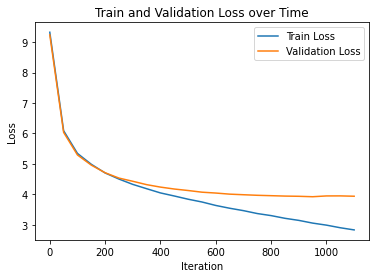

In [63]:
trained_model = train_model(filename, model, max_iters, eval_interval, plateau, patience, learning_rate)

In [65]:
# generate from the model
prompt = "Four score and seven years ago our fathers brought forth on this continent, a new nation, conceived in Liberty, and dedicated to the proposition that all men are created equal."
context = torch.tensor(gpt2enc.encode(prompt), dtype=torch.long, device=device).unsqueeze(0) # add batch dimension
generated_tokens = trained_model.generate(context, max_new_tokens=500)[0].tolist()
generated_text = gpt2enc.decode(generated_tokens)
print(generated_text)

# Output the generated text to a file
with open('lincoln_nn_llm_text.txt', 'w') as f:
    f.write(generated_text)

Four score and seven years ago our fathers brought forth on this continent, a new nation, conceived in Liberty, and dedicated to the proposition that all men are created equal. We well spoken of even Territories and Fillmore men, where all of us not to be recognizing us. [Mr. Lincoln read ``three cheers to make War of the reporter and answer around,'' ``abilities,'' ``squelched out,''---which he may be an amendment, and inserting ``oubt'' of the ``No clear articles.'' At the State of this, he admitted at least when he declares that is the first body of the National Bank, the community will be justified in the House of Representatives, and which were of the power oversl---that is to be spread upon that resolution. He insisted that, and therefore, nothing else shall be the exposition of the removal under that operation or by a commission of signers, applied  at the least. That Prince's strains, by what was founded in the House of Representatives, at pages It happens and on public Journal